# DDPLKO Moduł 9 - praca domowa - Self-Supervised Learning

To dziewiąta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [ ] Wykonanie treningu SSL z wykorzystaniem jednej z metod, wybierz framework i metodę dowolnie
- [ ] dla zbioru danych STL10:
  - [ ] Trening SSL na unlabelled, 100k zdjęć
  - [ ] Trening od zera na zbiorze train, 5k zdjęć
  - [ ] Trening transfer learning modelu z SSL na zbiorze train, 5k zdjęć
- [ ] Udostępnij wykres z porównaniem wyników validation accuracy na Discordzie `#klasyfikacja-wyniki`


# STL10

Ten zbiór wygodnie wczytasz w TensorFlow jak i w PyTorchu, linki poniżej:

- Strona zbioru: https://cs.stanford.edu/~acoates/stl10/
- PyTorch Torchvision dataset: https://pytorch.org/vision/stable/datasets.html#stl10
- TensorFlow dataset:https://www.tensorflow.org/datasets/catalog/stl10

![STL10](https://cs.stanford.edu/~acoates/stl10/images.png)


W przypadku problemów z wielkością tego zbioru:
- możesz pracować na rozdzielczości np. 32x32px
- możesz ograniczyć wielkość zbioru unlabelled (ale lepiej zmniejsz rozdzielczość)

Extra - dodatkowo możesz:
- przeprowadzić eksperyment z SSL dla różnej wielkości modeli (np. R18 vs R101 czy EffNetB0 vs EffNetB4 itp.)

# STL10 Dataset

In [ ]:
!pip install lightly

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)
from collections import defaultdict

import numpy as np

import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import lightly
from sklearn.metrics import accuracy_score

from torchvision.datasets import STL10
from torchvision import transforms

/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.19. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==1.1.21
  warnings.warn(Warning(warning))


In [4]:
train = STL10(root='/media/jakub/D/deep_learning_course/STL10/',
             split='unlabeled')

test = STL10(root='/media/jakub/D/deep_learning_course/STL10/',
             split='test')

train_supervised = STL10(root='/media/jakub/D/deep_learning_course/STL10/',
                         split='train')

In [5]:
seed = 1
pl.seed_everything(seed)

Global seed set to 1


1

# Trening SSL na unlabelled, 100k zdjęć

In [6]:
num_workers = 0
batch_size = 256
max_epochs = 40
input_size = 32
num_classes = 10
gpus = 1

In [7]:
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# datasets
train_dataset = lightly.data.LightlyDataset.from_torch_dataset(train, transform=transform)
test_dataset = lightly.data.LightlyDataset.from_torch_dataset(test, transform=transform)

# transforms
collate_func = lightly.data.SimCLRCollateFunction(
    input_size=input_size,
    gaussian_blur=0.)

# dataloaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_func,
    drop_last=True,
    num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_func,
    drop_last=False,
    num_workers=num_workers)

### SimCLR model

In [9]:
class SimCLR_ResNet(pl.LightningModule):
    def __init__(self, size=18):
        super().__init__()
        
        if size == 18:
            resnet = torchvision.models.resnet18(pretrained=False)
            num_ftrs = 512
        
        elif size == 50:
            resnet = torchvision.models.resnet50(pretrained=False)
            num_ftrs = 2048
            
        elif size == 101:
            resnet = torchvision.models.resnet101(pretrained=False)
            num_ftrs = 2048
            
        else:
            raise ValueError('Wrong resnet size! Supports only 18, 50 and 101')
            
        backbone = nn.Sequential(
            *list(resnet.children())[:-1])
        
        self.resnet_simclr = lightly.models.SimCLR(backbone, num_ftrs, out_dim=num_ftrs)
        
        self.criterion = lightly.loss.NTXentLoss()
        
        self.loss_train = []
        self.loss_val = []
        
    def forward(self, x):
        self.resnet_simclr(x)
        
    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        y0, y1 = self.resnet_simclr(x0, x1)
        loss = self.criterion(y0, y1)
        return {'loss': loss}
    
    def training_epoch_end(self, outputs):
        mean_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.loss_train.append(mean_loss.detach().cpu().item())
        
    def validation_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        y0, y1 = self.resnet_simclr(x0, x1)
        loss = self.criterion(y0, y1)
        self.log('val_loss', loss)
        return {'loss': loss}
    
    def validation_epoch_end(self, outputs):
        mean_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.loss_val.append(mean_loss.detach().cpu().item())
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.resnet_simclr.parameters())
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_epochs)
        return [optimizer], [scheduler]

In [27]:
model_simclr = SimCLR_ResNet(size=18)

trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0, 
                     weights_save_path='./models/',
                     resume_from_checkpoint='./models/lightning_logs/version_19/checkpoints/epoch=19-step=7799.ckpt')

trainer.fit(model_simclr, train_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint file at ./models/lightning_logs/version_19/checkpoints/epoch=19-step=7799.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restored all states from the checkpoint file at ./models/lightning_logs/version_19/checkpoints/epoch=19-step=7799.ckpt

  | Name          | Type       | Params
---------------------------------------------
0 | resnet_simclr | SimCLR     | 11.7 M
1 | criterion     | NTXentLoss | 0     
---------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.807    Total estimated model params size (MB)


Epoch 20:  92%|██████████▏| 390/422 [04:26<00:21,  1.47it/s, loss=4.9, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 21:  92%|█████████▏| 390/422 [04:34<00:22,  1.42it/s, loss=4.89, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 22:  92%|█████████▏| 390/422 [04:35<00:22,  1.42it/s, loss=4.88, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 23:  92%|██████████▏| 390/422 [04:33<00:22,  1.43it/s, loss=4.9, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 24:  92%|█████████▏| 390/422 [04:45<00:23,  1.37it/s, loss=4.89, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 25:  92%|██████████▏| 390/422 [04:42<00:23,  1.38it/s, loss=4.9, v_num=24]
Validating: 0it [00:00, ?it/s]
Validating:  50%|███████████████▌               | 16/32 [00:09<00:09,  1.68it/s]


Epoch 26:  92%|█████████▏| 390/422 [04:54<00:24,  1.33it/s, loss=4.91, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 27:  92%|█████████▏| 390/422 [04:53<00:23,  1.33it/s, loss=4.91, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 28:  92%|██████████▏| 390/422 [04:48<00:23,  1.36it/s, loss=4.9, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 29:  92%|██████████▏| 390/422 [04:55<00:24,  1.32it/s, loss=4.9, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 30:  92%|██████████▏| 390/422 [04:50<00:23,  1.35it/s, loss=4.9, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 31:  92%|█████████▏| 390/422 [04:32<00:22,  1.43it/s, loss=4.91, v_num=24]
Validating: 0it [00:00, ?it/s]
Validating:  12%|████                            | 4/32 [00:02<00:15,  1.80it/s]


Epoch 32:  92%|██████████▏| 390/422 [04:17<00:21,  1.52it/s, loss=4.9, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 33:  92%|█████████▏| 390/422 [04:17<00:21,  1.52it/s, loss=4.91, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 34:  92%|██████████▏| 390/422 [04:20<00:21,  1.50it/s, loss=4.9, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 35:  92%|██████████▏| 390/422 [04:17<00:21,  1.52it/s, loss=4.9, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 36:  92%|█████████▏| 390/422 [04:47<00:23,  1.36it/s, loss=4.91, v_num=24]
Validating: 0it [00:00, ?it/s]
Validating:  81%|█████████████████████████▏     | 26/32 [00:16<00:03,  1.51it/s]


Epoch 37:  92%|█████████▏| 390/422 [04:47<00:23,  1.36it/s, loss=4.89, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 38:  92%|██████████▏| 390/422 [04:48<00:23,  1.36it/s, loss=4.9, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 39:  92%|█████████▏| 390/422 [04:50<00:23,  1.35it/s, loss=4.89, v_num=24]
Validating: 0it [00:00, ?it/s]
Epoch 39: 100%|██████████| 422/422 [05:10<00:00,  1.36it/s, loss=4.89, v_num=24]


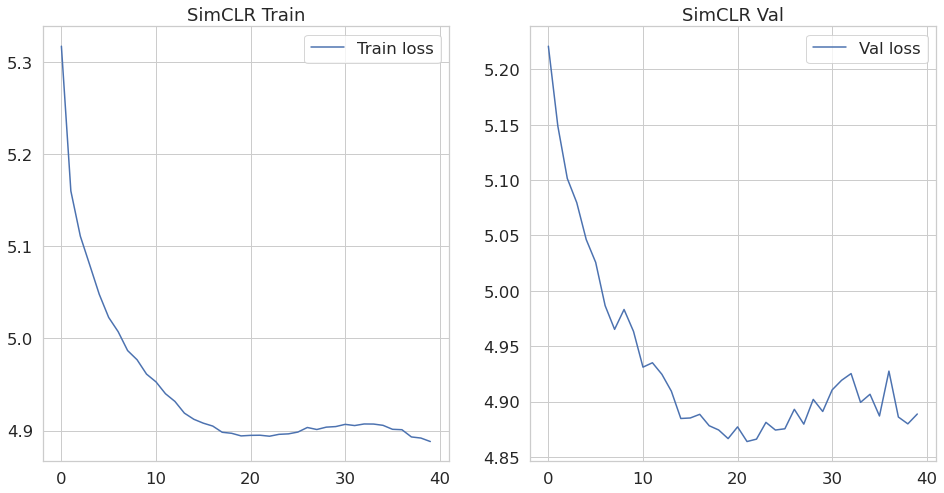

In [32]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.plot(np.asarray(logs[0]), label='Train loss')
plt.title('SimCLR Train')
plt.legend()

plt.subplot(122)
plt.plot(np.asarray(logs[1]), label='Val loss')
plt.title('SimCLR Val')
plt.legend();

In [47]:
max_epochs=30

model_simclr = SimCLR_ResNet(size=101)

trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0, 
                     weights_save_path='./models/resnet101/',
                     resume_from_checkpoint='./models/resnet101/lightning_logs/version_27/checkpoints/epoch=19-step=7799.ckpt')

trainer.fit(model_simclr, train_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint file at ./models/resnet101/lightning_logs/version_27/checkpoints/epoch=19-step=7799.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restored all states from the checkpoint file at ./models/resnet101/lightning_logs/version_27/checkpoints/epoch=19-step=7799.ckpt

  | Name          | Type       | Params
---------------------------------------------
0 | resnet_simclr | SimCLR     | 50.9 M
1 | criterion     | NTXentLoss | 0     
---------------------------------------------
50.9 M    Trainable params
0         Non-trainable params
50.9 M    Total params
203.571   Total estimated model params size (MB)
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the

Epoch 20:  92%|█████████▏| 390/422 [06:30<00:31,  1.00it/s, loss=4.97, v_num=28]
Validating: 0it [00:00, ?it/s]
Epoch 21:  92%|█████████▏| 390/422 [06:57<00:34,  1.07s/it, loss=4.97, v_num=28]
Validating: 0it [00:00, ?it/s]
Epoch 22:  92%|█████████▏| 390/422 [06:57<00:34,  1.07s/it, loss=4.97, v_num=28]
Validating: 0it [00:00, ?it/s]
Epoch 23:  92%|█████████▏| 390/422 [07:00<00:34,  1.08s/it, loss=4.97, v_num=28]
Validating: 0it [00:00, ?it/s]
Epoch 24:  92%|█████████▏| 390/422 [07:01<00:34,  1.08s/it, loss=4.96, v_num=28]
Validating: 0it [00:00, ?it/s]
Epoch 25:  92%|█████████▏| 390/422 [07:02<00:34,  1.08s/it, loss=4.97, v_num=28]
Validating: 0it [00:00, ?it/s]
Validating:  62%|███████████████████▍           | 20/32 [00:14<00:08,  1.34it/s]


Epoch 26:  92%|█████████▏| 390/422 [07:11<00:35,  1.10s/it, loss=4.95, v_num=28]
Validating: 0it [00:00, ?it/s]
Epoch 27:  92%|█████████▏| 390/422 [06:27<00:31,  1.01it/s, loss=4.97, v_num=28]
Validating: 0it [00:00, ?it/s]
Epoch 28:  92%|█████████▏| 390/422 [06:38<00:32,  1.02s/it, loss=4.97, v_num=28]
Validating: 0it [00:00, ?it/s]
Epoch 29:  92%|█████████▏| 390/422 [06:24<00:31,  1.02it/s, loss=4.96, v_num=28]
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████| 422/422 [06:47<00:00,  1.04it/s, loss=4.96, v_num=28]


In [45]:
resnet101_logs = (model_simclr.loss_train, model_simclr.loss_val)

In [50]:
resnet101_logs[0].extend(model_simclr.loss_train)
resnet101_logs[1].extend(model_simclr.loss_val)

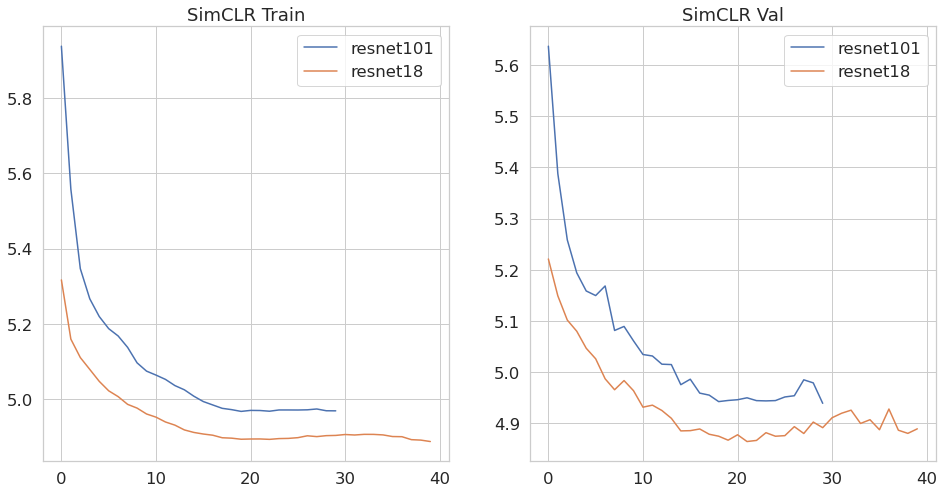

In [52]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.plot(np.asarray(resnet101_logs[0]), label='resnet101')
plt.plot(np.asarray(logs[0]), label='resnet18')
plt.title('SimCLR Train')
plt.legend()

plt.subplot(122)
plt.plot(np.asarray(resnet101_logs[1]), label='resnet101')
plt.plot(np.asarray(logs[1]), label='resnet18')

plt.title('SimCLR Val')
plt.legend();

In [25]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


In [14]:
max_epochs=40

model_simclr = SimCLR_ResNet(size=50)

trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0, 
                     weights_save_path='./models/resnet50/',
                     resume_from_checkpoint='./models/resnet50/lightning_logs/version_3/checkpoints/epoch=12-step=5069.ckpt',
                     callbacks=[EarlyStopping(
                         monitor='val_loss',
                         mode='min',
                         verbose=True,
                         patience=3
                     )])

trainer.fit(model_simclr, train_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint file at ./models/resnet50/lightning_logs/version_3/checkpoints/epoch=12-step=5069.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Restored all states from the checkpoint file at ./models/resnet50/lightning_logs/version_3/checkpoints/epoch=12-step=5069.ckpt

  | Name          | Type       | Params
---------------------------------------------
0 | resnet_simclr | SimCLR     | 31.9 M
1 | criterion     | NTXentLoss | 0     
---------------------------------------------
31.9 M    Trainable params
0         Non-trainable params
31.9 M    Total params
127.603   Total estimated model params size (MB)


Epoch 13:  92%|████████████▉ | 390/422 [05:22<00:26,  1.21it/s, loss=5, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████████| 422/422 [05:41<00:00,  1.24it/s, loss=5, v_num=5]
                                                                                

Metric val_loss improved. New best score: 5.006


Epoch 14:  92%|██████████▏| 390/422 [05:18<00:26,  1.23it/s, loss=4.99, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|███████████| 422/422 [05:38<00:00,  1.25it/s, loss=4.99, v_num=5]
                                                                                

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 4.987


Epoch 15:  92%|██████████▏| 390/422 [05:19<00:26,  1.22it/s, loss=4.98, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 16:  92%|██████████▏| 390/422 [05:19<00:26,  1.22it/s, loss=4.97, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 16: 100%|███████████| 422/422 [05:38<00:00,  1.25it/s, loss=4.97, v_num=5]
                                                                                

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 4.981


Epoch 17:  92%|██████████▏| 390/422 [05:19<00:26,  1.22it/s, loss=4.96, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 17: 100%|███████████| 422/422 [05:38<00:00,  1.25it/s, loss=4.96, v_num=5]
                                                                                

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 4.958


Epoch 18:  92%|██████████▏| 390/422 [05:19<00:26,  1.22it/s, loss=4.96, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 19:  92%|██████████▏| 390/422 [05:18<00:26,  1.23it/s, loss=4.95, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 20:  92%|██████████▏| 390/422 [05:30<00:27,  1.18it/s, loss=4.97, v_num=5]
Validating: 0it [00:00, ?it/s]
Epoch 20: 100%|███████████| 422/422 [05:51<00:00,  1.20it/s, loss=4.97, v_num=5]
                                                                                

Monitored metric val_loss did not improve in the last 3 records. Best score: 4.958. Signaling Trainer to stop.


Epoch 20: 100%|███████████| 422/422 [05:52<00:00,  1.20it/s, loss=4.97, v_num=5]


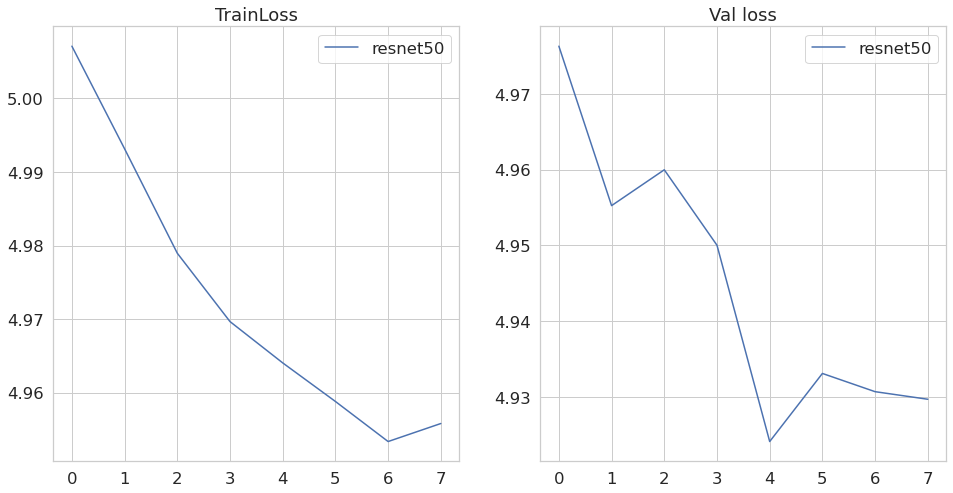

In [17]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.plot(np.asarray(model_simclr.loss_train), label='resnet50')
plt.title('TrainLoss')
plt.legend()

plt.subplot(122)
plt.plot(np.asarray(model_simclr.loss_val), label='resnet50')
plt.title('Val loss')
plt.legend()

### Resnet 50 wypadł gorzej od 18 dlatego pominięto kolejne treningi

# Trening od zera na zbiorze train, 5k zdjęć

In [10]:
train_supervised_dataset = lightly.data.LightlyDataset.from_torch_dataset(train_supervised, transform=transform)


train_super_loader = torch.utils.data.DataLoader(
    train_supervised_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_func,
    drop_last=True,
    num_workers=num_workers)

In [46]:
class Classifier(pl.LightningModule):
    def __init__(self, model, transfer_learning=False, fine_tune=False):
        super().__init__()
        
        self.model = model
        self.transfer_learning = transfer_learning
        self.fine_tune = fine_tune
        
        if self.transfer_learning:
            for p in self.model.parameters():
                p.requires_grad = False
            
            num_ftrs = self.model[-2][-1].conv1.in_channels 
            
            self.fc = nn.Linear(num_ftrs, num_classes)
            
        
        if self.fine_tune:
            
            for p in self.model.parameters():
                p.requires_grad = True

        self.history = defaultdict(lambda: [])
        
    def forward(self, x):
        if self.transfer_learning:
            with torch.no_grad():
                y_hat = self.model(x).squeeze()
            return self.fc(y_hat)
        
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        x = x[0]
        y_hat = self.forward(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        y_hat = nn.functional.softmax(y_hat, dim=1)
        acc = accuracy_score(y.detach().cpu().numpy(), torch.max(y_hat, dim=1).indices.detach().cpu().numpy())
        return {'loss': loss, 'accuracy': acc}
        
    def training_epoch_end(self, outputs):
        mean_loss = torch.stack([x['loss'] for x in outputs]).mean()
        mean_acc = np.stack([x['accuracy'] for x in outputs]).mean()
        self.history['train_loss'].append(mean_loss.detach().cpu().item())
        self.history['train_acc'].append(mean_acc.item())
        
    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        x = x[0]
        y_hat = self.forward(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        y_hat = nn.functional.softmax(y_hat, dim=1)
        acc = accuracy_score(y.detach().cpu().numpy(), torch.max(y_hat, dim=1).indices.detach().cpu().numpy())
        
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        
        return {'loss': loss, 'accuracy': acc}
    
    def validation_epoch_end(self, outputs):
        mean_loss = torch.stack([x['loss'] for x in outputs]).mean()
        mean_acc = np.stack([x['accuracy'] for x in outputs]).mean()
        self.history['val_loss'].append(mean_loss.detach().cpu().item())
        self.history['val_acc'].append(mean_acc.item())
        
    def configure_optimizers(self):
        lr = 0.0003 if self.fine_tune else 0.001
        if self.transfer_learning:
            optim = torch.optim.Adam(self.fc.parameters(), lr=lr)
        else:
            optim = torch.optim.Adam(self.model.parameters(), lr=lr)
        
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        
        return [optim], [scheduler]
        

In [85]:
max_epochs=30

resnet = torchvision.models.resnet18(pretrained=False, num_classes=num_classes)
resnet18_classifier = Classifier(resnet)

trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0,
                     callbacks=[EarlyStopping(
                         monitor='val_acc',
                         mode='max',
                         verbose=True,
                         patience=5
                     )])

trainer.fit(resnet18_classifier, train_super_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (19) is smaller than the logging interval

Epoch 0:  37%|█████▏        | 19/51 [00:10<00:16,  1.91it/s, loss=2.2, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████| 51/51 [00:26<00:00,  1.97it/s, loss=2.2, v_num=47]
                                                                                

Metric val_acc improved. New best score: 0.212


Epoch 1:  39%|█████        | 20/51 [00:10<00:15,  1.98it/s, loss=1.91, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█████████████| 51/51 [00:26<00:00,  1.94it/s, loss=1.91, v_num=47]
                                                                                

Metric val_acc improved by 0.084 >= min_delta = 0.0. New best score: 0.296


Epoch 2:  39%|█████        | 20/51 [00:10<00:16,  1.92it/s, loss=1.83, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████████| 51/51 [00:27<00:00,  1.91it/s, loss=1.83, v_num=47]
                                                                                

Metric val_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.307


Epoch 3:  39%|█████        | 20/51 [00:11<00:17,  1.81it/s, loss=1.77, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████████| 51/51 [00:30<00:00,  1.72it/s, loss=1.77, v_num=47]
                                                                                

Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.309


Epoch 4:  39%|█████        | 20/51 [00:12<00:17,  1.73it/s, loss=1.76, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████████| 51/51 [00:30<00:00,  1.71it/s, loss=1.76, v_num=47]
                                                                                

Metric val_acc improved by 0.026 >= min_delta = 0.0. New best score: 0.335


Epoch 5:  39%|█████        | 20/51 [00:13<00:19,  1.60it/s, loss=1.72, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 6:  39%|█████        | 20/51 [00:11<00:17,  1.78it/s, loss=1.67, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████████| 51/51 [00:30<00:00,  1.70it/s, loss=1.67, v_num=47]
                                                                                

Metric val_acc improved by 0.013 >= min_delta = 0.0. New best score: 0.347


Epoch 7:  39%|█████        | 20/51 [00:11<00:17,  1.79it/s, loss=1.67, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|█████████████| 51/51 [00:27<00:00,  1.86it/s, loss=1.67, v_num=47]
                                                                                

Metric val_acc improved by 0.014 >= min_delta = 0.0. New best score: 0.361


Epoch 8:  39%|█████        | 20/51 [00:11<00:17,  1.78it/s, loss=1.65, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|█████████████| 51/51 [00:29<00:00,  1.76it/s, loss=1.65, v_num=47]
                                                                                

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.363


Epoch 9:  39%|█████        | 20/51 [00:13<00:20,  1.53it/s, loss=1.61, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|█████████████| 51/51 [00:30<00:00,  1.68it/s, loss=1.61, v_num=47]
                                                                                

Metric val_acc improved by 0.013 >= min_delta = 0.0. New best score: 0.376


Epoch 10:  39%|████▋       | 20/51 [00:12<00:18,  1.71it/s, loss=1.59, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|████████████| 51/51 [00:29<00:00,  1.75it/s, loss=1.59, v_num=47]
                                                                                

Metric val_acc improved by 0.023 >= min_delta = 0.0. New best score: 0.398


Epoch 11:  39%|████▋       | 20/51 [00:11<00:16,  1.85it/s, loss=1.58, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 12:  39%|████▋       | 20/51 [00:11<00:16,  1.86it/s, loss=1.55, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|████████████| 51/51 [00:28<00:00,  1.83it/s, loss=1.55, v_num=47]
                                                                                

Metric val_acc improved by 0.007 >= min_delta = 0.0. New best score: 0.406


Epoch 13:  39%|████▋       | 20/51 [00:11<00:16,  1.85it/s, loss=1.55, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|████████████| 51/51 [00:28<00:00,  1.83it/s, loss=1.55, v_num=47]
                                                                                

Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.408


Epoch 14:  39%|████▋       | 20/51 [00:12<00:17,  1.73it/s, loss=1.48, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|████████████| 51/51 [00:29<00:00,  1.73it/s, loss=1.48, v_num=47]
                                                                                

Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.412


Epoch 15:  39%|████▋       | 20/51 [00:11<00:16,  1.86it/s, loss=1.48, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|████████████| 51/51 [00:28<00:00,  1.84it/s, loss=1.48, v_num=47]
                                                                                

Metric val_acc improved by 0.017 >= min_delta = 0.0. New best score: 0.429


Epoch 16:  39%|████▋       | 20/51 [00:11<00:16,  1.83it/s, loss=1.44, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 17:  39%|████▋       | 20/51 [00:11<00:16,  1.86it/s, loss=1.44, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 17: 100%|████████████| 51/51 [00:28<00:00,  1.83it/s, loss=1.44, v_num=47]
                                                                                

Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.429


Epoch 18:  39%|████▋       | 20/51 [00:11<00:16,  1.83it/s, loss=1.42, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 18: 100%|████████████| 51/51 [00:28<00:00,  1.82it/s, loss=1.42, v_num=47]
                                                                                

Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.437


Epoch 19:  39%|████▋       | 20/51 [00:11<00:16,  1.85it/s, loss=1.41, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 19: 100%|████████████| 51/51 [00:28<00:00,  1.85it/s, loss=1.41, v_num=47]
                                                                                

Metric val_acc improved by 0.018 >= min_delta = 0.0. New best score: 0.455


Epoch 20:  39%|████▋       | 20/51 [00:11<00:16,  1.84it/s, loss=1.39, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 20: 100%|████████████| 51/51 [00:28<00:00,  1.84it/s, loss=1.39, v_num=47]
                                                                                

Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.458


Epoch 21:  39%|████▋       | 20/51 [00:11<00:16,  1.83it/s, loss=1.38, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 21: 100%|████████████| 51/51 [00:28<00:00,  1.83it/s, loss=1.38, v_num=47]
                                                                                

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.463


Epoch 22:  39%|████▋       | 20/51 [00:11<00:16,  1.86it/s, loss=1.34, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 22: 100%|████████████| 51/51 [00:28<00:00,  1.84it/s, loss=1.34, v_num=47]
                                                                                

Metric val_acc improved by 0.011 >= min_delta = 0.0. New best score: 0.474


Epoch 23:  39%|████▋       | 20/51 [00:11<00:16,  1.85it/s, loss=1.33, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 24:  39%|████▋       | 20/51 [00:13<00:19,  1.58it/s, loss=1.33, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 24: 100%|████████████| 51/51 [00:30<00:00,  1.71it/s, loss=1.33, v_num=47]
                                                                                

Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.479


Epoch 25:  39%|████▋       | 20/51 [00:11<00:16,  1.85it/s, loss=1.33, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 26:  39%|████▋       | 20/51 [00:11<00:16,  1.84it/s, loss=1.31, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 27:  39%|█████        | 20/51 [00:11<00:16,  1.87it/s, loss=1.3, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 28:  39%|████▋       | 20/51 [00:14<00:21,  1.45it/s, loss=1.29, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 28: 100%|████████████| 51/51 [00:31<00:00,  1.66it/s, loss=1.29, v_num=47]
                                                                                

Metric val_acc improved by 0.014 >= min_delta = 0.0. New best score: 0.493


Epoch 29:  39%|█████        | 20/51 [00:11<00:16,  1.85it/s, loss=1.3, v_num=47]
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|█████████████| 51/51 [00:30<00:00,  1.73it/s, loss=1.3, v_num=47]


In [86]:
resnet = torchvision.models.resnet101(pretrained=False, num_classes=num_classes)
resnet101_classifier = Classifier(resnet)

trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0,
                     callbacks=[EarlyStopping(
                         monitor='val_acc',
                         mode='max',
                         verbose=True,
                         patience=5
                     )])

trainer.fit(resnet101_classifier, train_super_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 42.5 M
---------------------------------
42.5 M    Trainable params
0         Non-trainable params
42.5 M    Total params
170.083   Total estimated model params size (MB)
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (19) is smaller than the logging interval

Epoch 0:  37%|████▊        | 19/51 [00:14<00:23,  1.37it/s, loss=2.74, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|█████████████| 51/51 [00:33<00:00,  1.56it/s, loss=2.74, v_num=48]
                                                                                

Metric val_acc improved. New best score: 0.112


Epoch 1:  39%|█████        | 20/51 [00:14<00:21,  1.46it/s, loss=2.25, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█████████████| 51/51 [00:33<00:00,  1.56it/s, loss=2.25, v_num=48]
                                                                                

Metric val_acc improved by 0.068 >= min_delta = 0.0. New best score: 0.181


Epoch 2:  39%|█████        | 20/51 [00:15<00:22,  1.36it/s, loss=2.17, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████████| 51/51 [00:34<00:00,  1.51it/s, loss=2.17, v_num=48]
                                                                                

Metric val_acc improved by 0.014 >= min_delta = 0.0. New best score: 0.195


Epoch 3:  39%|█████        | 20/51 [00:14<00:21,  1.44it/s, loss=2.13, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████████| 51/51 [00:33<00:00,  1.55it/s, loss=2.13, v_num=48]
                                                                                

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.200


Epoch 4:  39%|█████        | 20/51 [00:15<00:23,  1.35it/s, loss=2.07, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████████| 51/51 [00:34<00:00,  1.50it/s, loss=2.07, v_num=48]
                                                                                

Metric val_acc improved by 0.028 >= min_delta = 0.0. New best score: 0.228


Epoch 5:  39%|█████        | 20/51 [00:14<00:21,  1.44it/s, loss=2.09, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████████| 51/51 [00:33<00:00,  1.55it/s, loss=2.09, v_num=48]
                                                                                

Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.231


Epoch 6:  39%|█████        | 20/51 [00:14<00:21,  1.45it/s, loss=1.99, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████████| 51/51 [00:33<00:00,  1.55it/s, loss=1.99, v_num=48]
                                                                                

Metric val_acc improved by 0.031 >= min_delta = 0.0. New best score: 0.262


Epoch 7:  39%|█████        | 20/51 [00:16<00:24,  1.28it/s, loss=1.93, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|█████████████| 51/51 [00:36<00:00,  1.44it/s, loss=1.93, v_num=48]
                                                                                

Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.262


Epoch 8:  39%|█████        | 20/51 [00:15<00:22,  1.38it/s, loss=1.91, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 9:  39%|█████        | 20/51 [00:14<00:21,  1.44it/s, loss=1.92, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|█████████████| 51/51 [00:33<00:00,  1.55it/s, loss=1.92, v_num=48]
                                                                                

Metric val_acc improved by 0.022 >= min_delta = 0.0. New best score: 0.284


Epoch 10:  39%|████▋       | 20/51 [00:14<00:21,  1.44it/s, loss=1.92, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 11:  39%|████▋       | 20/51 [00:14<00:21,  1.44it/s, loss=1.86, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|████████████| 51/51 [00:33<00:00,  1.54it/s, loss=1.86, v_num=48]
                                                                                

Metric val_acc improved by 0.012 >= min_delta = 0.0. New best score: 0.297


Epoch 12:  39%|████▋       | 20/51 [00:14<00:21,  1.41it/s, loss=1.87, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 13:  39%|████▋       | 20/51 [00:15<00:22,  1.36it/s, loss=1.88, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|████████████| 51/51 [00:34<00:00,  1.52it/s, loss=1.88, v_num=48]
                                                                                

Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.297


Epoch 14:  39%|████▋       | 20/51 [00:14<00:21,  1.45it/s, loss=1.83, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|████████████| 51/51 [00:35<00:00,  1.47it/s, loss=1.83, v_num=48]
                                                                                

Metric val_acc improved by 0.014 >= min_delta = 0.0. New best score: 0.311


Epoch 15:  39%|████▋       | 20/51 [00:13<00:19,  1.58it/s, loss=1.79, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|████████████| 51/51 [00:30<00:00,  1.71it/s, loss=1.79, v_num=48]
                                                                                

Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.320


Epoch 16:  39%|████▋       | 20/51 [00:14<00:20,  1.48it/s, loss=1.78, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 17:  39%|█████        | 20/51 [00:13<00:19,  1.59it/s, loss=1.8, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 18:  39%|████▋       | 20/51 [00:13<00:19,  1.60it/s, loss=1.78, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 18: 100%|████████████| 51/51 [00:29<00:00,  1.74it/s, loss=1.78, v_num=48]
                                                                                

Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.320


Epoch 19:  39%|████▋       | 20/51 [00:13<00:19,  1.60it/s, loss=1.76, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 19: 100%|████████████| 51/51 [00:30<00:00,  1.73it/s, loss=1.76, v_num=48]
                                                                                

Metric val_acc improved by 0.016 >= min_delta = 0.0. New best score: 0.336


Epoch 20:  39%|████▋       | 20/51 [00:13<00:20,  1.55it/s, loss=1.73, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 21:  39%|████▋       | 20/51 [00:15<00:23,  1.34it/s, loss=1.76, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 21: 100%|████████████| 51/51 [00:34<00:00,  1.51it/s, loss=1.76, v_num=48]
                                                                                

Metric val_acc improved by 0.011 >= min_delta = 0.0. New best score: 0.347


Epoch 22:  39%|████▋       | 20/51 [00:14<00:21,  1.42it/s, loss=1.74, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 23:  39%|████▋       | 20/51 [00:14<00:21,  1.45it/s, loss=1.73, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 24:  39%|████▋       | 20/51 [00:15<00:22,  1.39it/s, loss=1.71, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 25:  39%|█████        | 20/51 [00:16<00:23,  1.30it/s, loss=1.7, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 25: 100%|█████████████| 51/51 [00:35<00:00,  1.48it/s, loss=1.7, v_num=48]
                                                                                

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.348


Epoch 26:  39%|████▋       | 20/51 [00:14<00:21,  1.45it/s, loss=1.69, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|████████████| 51/51 [00:33<00:00,  1.56it/s, loss=1.69, v_num=48]
                                                                                

Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.349


Epoch 27:  39%|████▋       | 20/51 [00:15<00:22,  1.37it/s, loss=1.69, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|████████████| 51/51 [00:35<00:00,  1.48it/s, loss=1.69, v_num=48]
                                                                                

Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.349


Epoch 28:  39%|████▋       | 20/51 [00:15<00:23,  1.33it/s, loss=1.69, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 29:  39%|████▋       | 20/51 [00:15<00:22,  1.38it/s, loss=1.68, v_num=48]
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|████████████| 51/51 [00:35<00:00,  1.48it/s, loss=1.68, v_num=48]


In [53]:
%matplotlib inline
def plot_results(models, labels):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for model in models:
        for metric, values in model.history.items():
            epochs = list(range(0, len(values)))
            row = 0 if metric.split('_')[0] == 'train' else 1
            col = 0 if metric.split('_')[1] == 'loss' else 1
            
            axs[row, col].plot(epochs, values)
            axs[row, col].set_title(' '.join(metric.split('_')))
            axs[row, col].legend(labels)

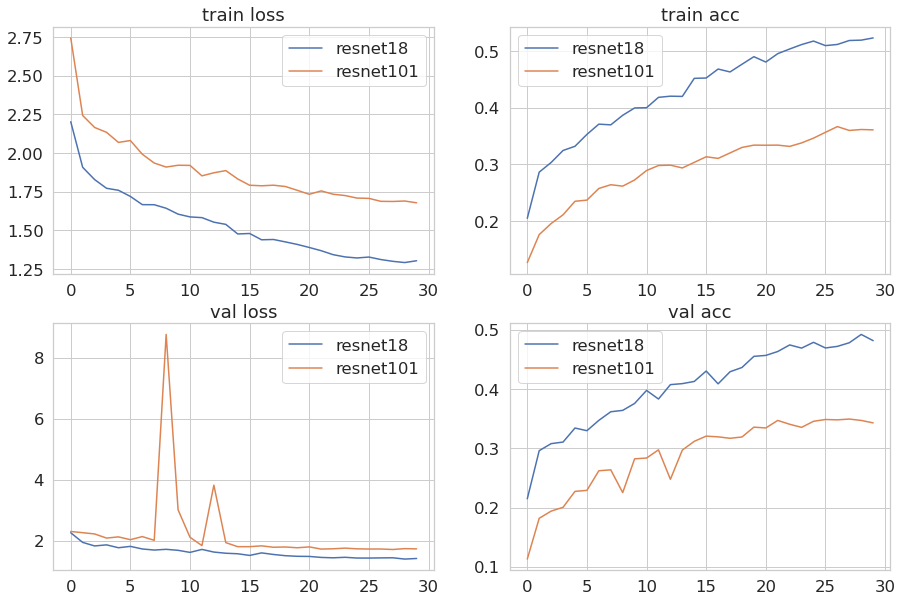

In [88]:
plot_results([resnet18_classifier, resnet101_classifier], labels=['resnet18', 'resnet101'])

# Trening transfer learning modelu z SSL na zbiorze train, 5k zdjęć

In [21]:
resnet18_ssl = SimCLR_ResNet.load_from_checkpoint('./models/lightning_logs/version_20/checkpoints/epoch=21-step=8579.ckpt') 

In [22]:
resnet101_ssl = SimCLR_ResNet.load_from_checkpoint('./models/resnet101/lightning_logs/version_27/checkpoints/epoch=19-step=7799.ckpt',
                                                  size=101)

In [26]:
resnet18_ssl.eval()
resnet18_classifier_tl = Classifier(resnet18_ssl.resnet_simclr.backbone, transfer_learning=True)

trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0,
                     callbacks=[EarlyStopping(
                         monitor='val_acc',
                         mode='max',
                         verbose=True,
                         patience=5
                     )])
trainer.fit(resnet18_classifier_tl, train_super_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 11.2 M
1 | fc    | Linear     | 5.1 K 
-------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training s

Epoch 0:  37%|█████▏        | 19/51 [00:09<00:15,  2.12it/s, loss=1.78, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████| 51/51 [00:24<00:00,  2.11it/s, loss=1.78, v_num=6]
                                                                                

Metric val_acc improved. New best score: 0.463


Epoch 1:  37%|█████▏        | 19/51 [00:09<00:14,  2.15it/s, loss=1.45, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████████| 51/51 [00:24<00:00,  2.13it/s, loss=1.45, v_num=6]
                                                                                

Metric val_acc improved by 0.021 >= min_delta = 0.0. New best score: 0.484


Epoch 2:  37%|█████▌         | 19/51 [00:09<00:14,  2.19it/s, loss=1.4, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 3:  37%|█████▌         | 19/51 [00:08<00:14,  2.28it/s, loss=1.4, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 4:  37%|█████▏        | 19/51 [00:09<00:15,  2.05it/s, loss=1.39, v_num=6]
Validating: 0it [00:00, ?it/s]
Validating:  81%|█████████████████████████▏     | 26/32 [00:12<00:02,  2.18it/s]


Epoch 5:  37%|█████▏        | 19/51 [00:08<00:13,  2.31it/s, loss=1.36, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████████| 51/51 [00:23<00:00,  2.23it/s, loss=1.36, v_num=6]
                                                                                

Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.488


Epoch 6:  37%|█████▏        | 19/51 [00:08<00:14,  2.28it/s, loss=1.37, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 7:  37%|█████▏        | 19/51 [00:08<00:13,  2.30it/s, loss=1.37, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████████| 51/51 [00:23<00:00,  2.24it/s, loss=1.37, v_num=6]
                                                                                

Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.491


Epoch 8:  37%|█████▏        | 19/51 [00:08<00:13,  2.29it/s, loss=1.35, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 9:  37%|█████▏        | 19/51 [00:08<00:13,  2.30it/s, loss=1.36, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 10:  37%|████▊        | 19/51 [00:08<00:13,  2.31it/s, loss=1.36, v_num=6]
Validating: 0it [00:00, ?it/s]
Validating:  81%|█████████████████████████▏     | 26/32 [00:12<00:02,  2.13it/s]


Epoch 10: 100%|█████████████| 51/51 [00:23<00:00,  2.25it/s, loss=1.36, v_num=6]
                                                                                

Metric val_acc improved by 0.016 >= min_delta = 0.0. New best score: 0.507


Epoch 11:  37%|████▊        | 19/51 [00:08<00:13,  2.31it/s, loss=1.35, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 12:  37%|████▊        | 19/51 [00:08<00:13,  2.30it/s, loss=1.33, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 13:  37%|████▊        | 19/51 [00:08<00:14,  2.27it/s, loss=1.34, v_num=6]
Validating: 0it [00:00, ?it/s]
Validating:  81%|█████████████████████████▏     | 26/32 [00:12<00:02,  2.16it/s]


Epoch 14:  37%|████▊        | 19/51 [00:08<00:14,  2.28it/s, loss=1.35, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 15:  37%|████▊        | 19/51 [00:08<00:14,  2.25it/s, loss=1.35, v_num=6]
Validating: 0it [00:00, ?it/s]
Epoch 15: 100%|█████████████| 51/51 [00:23<00:00,  2.23it/s, loss=1.35, v_num=6]
                                                                                

Monitored metric val_acc did not improve in the last 5 records. Best score: 0.507. Signaling Trainer to stop.


Epoch 15: 100%|█████████████| 51/51 [00:23<00:00,  2.22it/s, loss=1.35, v_num=6]


In [27]:
resnet101_ssl.eval()
resnet101_classifier_tl = Classifier(resnet101_ssl.resnet_simclr.backbone, transfer_learning=True)

trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0,
                     callbacks=[EarlyStopping(
                         monitor='val_acc',
                         mode='max',
                         verbose=True,
                         patience=5
                     )])
trainer.fit(resnet101_classifier_tl, train_super_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 42.5 M
1 | fc    | Linear     | 20.5 K
-------------------------------------
20.5 K    Trainable params
42.5 M    Non-trainable params
42.5 M    Total params
170.083   Total estimated model params size (MB)
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training s

Epoch 0:  37%|█████▏        | 19/51 [00:09<00:15,  2.12it/s, loss=1.85, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████| 51/51 [00:26<00:00,  1.97it/s, loss=1.85, v_num=7]
                                                                                

Metric val_acc improved. New best score: 0.401


Epoch 1:  39%|█████▍        | 20/51 [00:10<00:14,  2.08it/s, loss=1.64, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 2:  39%|█████▉         | 20/51 [00:11<00:16,  1.87it/s, loss=1.6, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|███████████████| 51/51 [00:30<00:00,  1.71it/s, loss=1.6, v_num=7]
                                                                                

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.405


Epoch 3:  39%|█████▍        | 20/51 [00:11<00:16,  1.84it/s, loss=1.58, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 4:  39%|█████▍        | 20/51 [00:10<00:15,  1.99it/s, loss=1.59, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████████| 51/51 [00:29<00:00,  1.76it/s, loss=1.59, v_num=7]
                                                                                

Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.412


Epoch 5:  39%|█████▍        | 20/51 [00:11<00:16,  1.89it/s, loss=1.58, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 6:  39%|█████▉         | 20/51 [00:10<00:16,  1.93it/s, loss=1.6, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|███████████████| 51/51 [00:29<00:00,  1.77it/s, loss=1.6, v_num=7]
                                                                                

Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.421


Epoch 7:  39%|█████▍        | 20/51 [00:10<00:16,  1.92it/s, loss=1.57, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 8:  39%|█████▍        | 20/51 [00:11<00:16,  1.89it/s, loss=1.56, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 9:  39%|█████▍        | 20/51 [00:10<00:16,  1.91it/s, loss=1.58, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 9:  90%|████████████▋ | 46/51 [00:26<00:02,  1.76it/s, loss=1.58, v_num=7]


Epoch 10:  39%|█████        | 20/51 [00:10<00:15,  2.01it/s, loss=1.56, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 11:  39%|█████        | 20/51 [00:10<00:15,  2.02it/s, loss=1.57, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█████████████| 51/51 [00:27<00:00,  1.86it/s, loss=1.57, v_num=7]
                                                                                

Monitored metric val_acc did not improve in the last 5 records. Best score: 0.421. Signaling Trainer to stop.


Epoch 11: 100%|█████████████| 51/51 [00:28<00:00,  1.84it/s, loss=1.57, v_num=7]


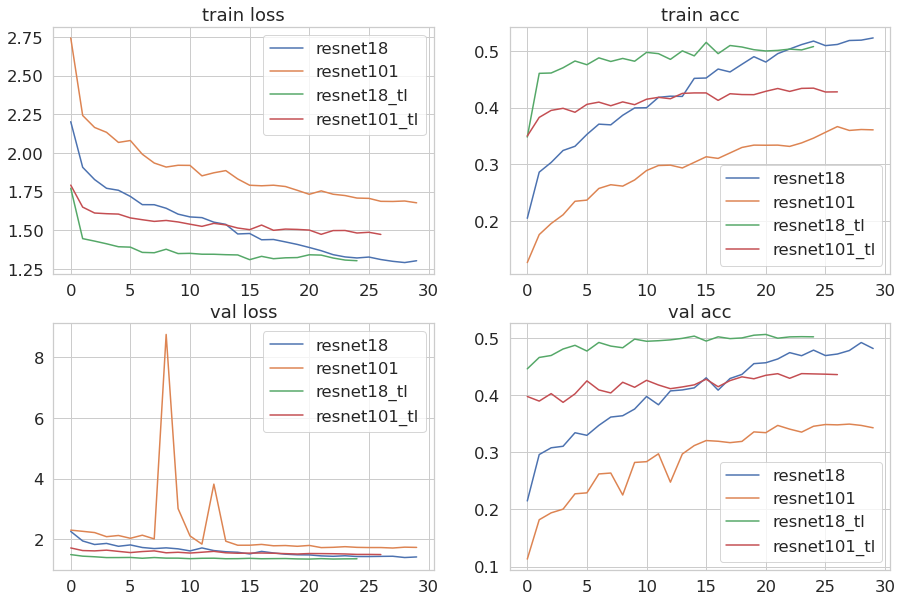

In [136]:
plot_results([resnet18_classifier, resnet101_classifier,
              resnet18_classifier_tl, resnet101_classifier_tl], 
             labels=['resnet18', 'resnet101', 'resnet18_tl', 'resnet101_tl'])

In [139]:
torch.save(resnet18_classifier_tl.model.state_dict(), './models/resnet18_tl.pt')
torch.save(resnet101_classifier_tl.model.state_dict(), './models/resnet101_tl.pt')

### Fine tuning

In [47]:
resnet18_classifier_ft = Classifier(resnet18_classifier_tl, fine_tune=True)

In [49]:
trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0,
                     callbacks=[EarlyStopping(
                         monitor='val_acc',
                         mode='max',
                         verbose=True,
                         patience=5
                     )])
trainer.fit(resnet18_classifier_ft, train_super_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Classifier | 11.2 M
-------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (19) is smaller than the 

Epoch 0:  37%|█████▏        | 19/51 [00:09<00:15,  2.12it/s, loss=1.35, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████| 51/51 [00:26<00:00,  2.00it/s, loss=1.35, v_num=8]
                                                                                

Metric val_acc improved. New best score: 0.496


Epoch 1:  37%|█████▏        | 19/51 [00:09<00:15,  2.02it/s, loss=1.33, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████████| 51/51 [00:26<00:00,  1.95it/s, loss=1.33, v_num=8]
                                                                                

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.502


Epoch 2:  37%|█████▏        | 19/51 [00:09<00:14,  2.14it/s, loss=1.31, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 3:  37%|█████▏        | 19/51 [00:09<00:14,  2.22it/s, loss=1.32, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 4:  37%|█████▏        | 19/51 [00:09<00:15,  2.13it/s, loss=1.33, v_num=8]
Validating: 0it [00:00, ?it/s]
Validating:  81%|█████████████████████████▏     | 26/32 [00:13<00:02,  2.04it/s]


Epoch 5:  37%|█████▏        | 19/51 [00:09<00:15,  2.03it/s, loss=1.32, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 6:  37%|█████▏        | 19/51 [00:09<00:14,  2.19it/s, loss=1.32, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████████| 51/51 [00:24<00:00,  2.14it/s, loss=1.32, v_num=8]
                                                                                

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.506


Epoch 7:  37%|█████▏        | 19/51 [00:09<00:14,  2.19it/s, loss=1.32, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 8:  37%|█████▏        | 19/51 [00:09<00:14,  2.14it/s, loss=1.32, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 9:  37%|█████▏        | 19/51 [00:09<00:15,  2.09it/s, loss=1.31, v_num=8]
Validating: 0it [00:00, ?it/s]
Validating:  81%|█████████████████████████▏     | 26/32 [00:12<00:02,  2.00it/s]


Epoch 10:  37%|████▊        | 19/51 [00:09<00:15,  2.07it/s, loss=1.32, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 11:  37%|████▊        | 19/51 [00:09<00:15,  2.07it/s, loss=1.32, v_num=8]
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█████████████| 51/51 [00:26<00:00,  1.99it/s, loss=1.32, v_num=8]
                                                                                

Monitored metric val_acc did not improve in the last 5 records. Best score: 0.506. Signaling Trainer to stop.


Epoch 11: 100%|█████████████| 51/51 [00:26<00:00,  1.98it/s, loss=1.32, v_num=8]


In [50]:
resnet101_classifier_ft = Classifier(resnet101_classifier_tl, fine_tune=True)

In [51]:
trainer = pl.Trainer(max_epochs=max_epochs, 
                     gpus=gpus, 
                     num_sanity_val_steps=0,
                     callbacks=[EarlyStopping(
                         monitor='val_acc',
                         mode='max',
                         verbose=True,
                         patience=5
                     )])
trainer.fit(resnet101_classifier_ft, train_super_loader, test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Classifier | 42.5 M
-------------------------------------
42.5 M    Trainable params
0         Non-trainable params
42.5 M    Total params
170.083   Total estimated model params size (MB)
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/jakub/anaconda3/envs/lightly_env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (19) is smaller than the 

Epoch 0:  39%|█████▍        | 20/51 [00:11<00:16,  1.90it/s, loss=1.53, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████████| 51/51 [00:30<00:00,  1.68it/s, loss=1.53, v_num=9]
                                                                                

Metric val_acc improved. New best score: 0.415


Epoch 1:  39%|█████▍        | 20/51 [00:10<00:15,  2.03it/s, loss=1.52, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████████| 51/51 [00:28<00:00,  1.80it/s, loss=1.52, v_num=9]
                                                                                

Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.423


Epoch 2:  39%|█████▍        | 20/51 [00:12<00:18,  1.71it/s, loss=1.51, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████████| 51/51 [00:30<00:00,  1.70it/s, loss=1.51, v_num=9]
                                                                                

Metric val_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.431


Epoch 3:  39%|█████▉         | 20/51 [00:10<00:15,  1.99it/s, loss=1.5, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 4:  39%|█████▍        | 20/51 [00:10<00:15,  1.99it/s, loss=1.51, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████████| 51/51 [00:28<00:00,  1.81it/s, loss=1.51, v_num=9]
                                                                                

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.431


Epoch 5:  39%|█████▍        | 20/51 [00:10<00:14,  2.09it/s, loss=1.52, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 6:  39%|█████▍        | 20/51 [00:10<00:15,  2.06it/s, loss=1.51, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████████| 51/51 [00:27<00:00,  1.88it/s, loss=1.51, v_num=9]
                                                                                

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.436


Epoch 7:  39%|█████▍        | 20/51 [00:10<00:14,  2.10it/s, loss=1.49, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 8:  39%|█████▍        | 20/51 [00:10<00:14,  2.07it/s, loss=1.49, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 9:  39%|█████▍        | 20/51 [00:10<00:14,  2.09it/s, loss=1.49, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 9:  90%|████████████▋ | 46/51 [00:24<00:02,  1.92it/s, loss=1.49, v_num=9]


Epoch 10:  39%|█████▍        | 20/51 [00:10<00:14,  2.08it/s, loss=1.5, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 11:  39%|█████        | 20/51 [00:10<00:16,  1.93it/s, loss=1.51, v_num=9]
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█████████████| 51/51 [00:29<00:00,  1.79it/s, loss=1.51, v_num=9]
                                                                                

Monitored metric val_acc did not improve in the last 5 records. Best score: 0.436. Signaling Trainer to stop.


Epoch 11: 100%|█████████████| 51/51 [00:29<00:00,  1.77it/s, loss=1.51, v_num=9]


# Summary / extra

### Fine tuning results

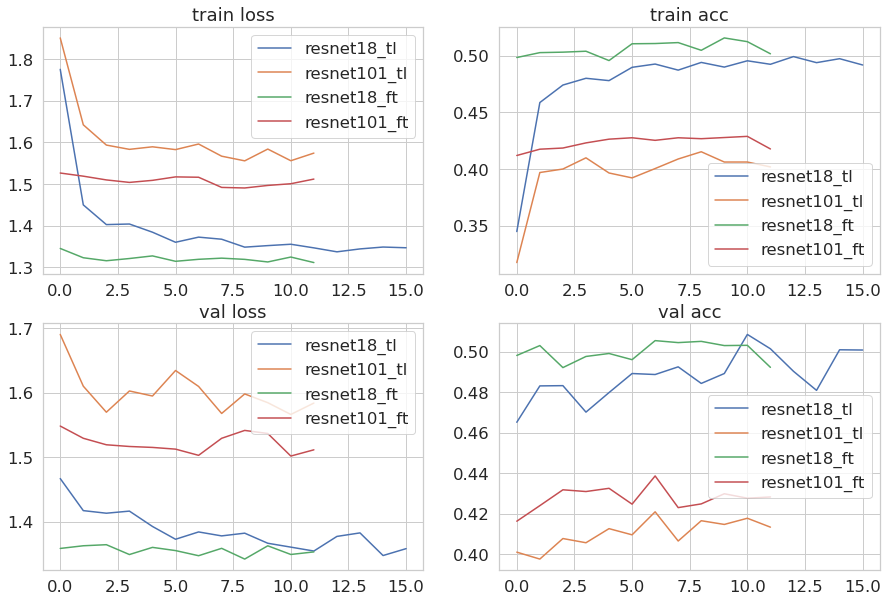

In [56]:
plot_results([resnet18_classifier_tl, resnet101_classifier_tl,
              resnet18_classifier_ft, resnet101_classifier_ft], 
             labels=['resnet18_tl', 'resnet101_tl', 'resnet18_ft', 'resnet101_ft'])

# Wyślij rozwiązanie
Możesz skorzystać z jednego z poniższych sposobów:
**mailem na specjalny adres** ze strony pracy domowej w panelu programu prześlij jedno z poniższych:
- notebooka (jeżeli plik ma mniej niż np. 10MB)
- notebooka w zipie
- link do Colaba (udostępniony)
- link do pliku przez GDrive/Dropboxa/WeTransfer/...
- pdfa (poprzez download as pdf)
- jako plik w repozytorium na np. GitHubie, by budować swoje portfolio (wtedy uważaj na wielkość pliku, najlepiej kilka MB, Max 25MB)

Najlepiej, by w notebooku było widać wyniki uruchomienia komórek, chyba, że przez nie plik będzie mieć 100+MB wtedy najlepiej Colab lub jakieś przemyślenie co poszło nie tak (zbyt dużo dużych zdjęć wyświetlonych w komórkach).

## Co otrzymasz?
Informację zwrotną z ewentualnymi sugestiami, komentarzami.